<a href="https://colab.research.google.com/github/hyaochn/RUP-Net/blob/master/RUP_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Residual U-Net + Pixel De-convolution Network**



1.   Import library
2.   Mount Google Drive to load dataset. Att: /X, /Y to load correctly.


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print("tensorflow version: ",tf.__version__)

import h5py
import numpy as np
import matplotlib.pyplot as plt


import tensorflow.keras as keras
import scipy.ndimage as snd


TensorFlow 2.x selected.
tensorflow version:  2.1.0


In [4]:
from google.colab import drive
drive.mount('gdrive')
#!ls "gdrive/My Drive/Deep-Learning/Data"


!pip install tensorflow_io

import tensorflow_io as tfio
print("tensorflow_io version: ",tfio.__version__)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive
     |████████████████████████████████| 20.1MB 159kB/s 
tensorflow_io version:  0.12.0


In [0]:
#number of training cases used in one step
BATCH_SIZE=2
#one epoch trains all training cases, One epoch=BATCH_SIZE*steps
EPOCH=5

#3D image, train set (batch, in_depth, in_height, in_width, in_channels)
CHANNEL_AXIS=4

#number of filters at start node
START_NUM_OF_FILTERS=32

#number of class, for classification = 2
NUM_CLASS=2

#number of epoch to augment, if 2, 4*orig size new images are generated
#because one epoch including flip and rotate
AUGMENT_EPOCH=0 

#Use residual network
ISRES=True
#Use MaxPooling or not
ISPOOL=False
#Deconvolution layer: deconv, pdn, upsampling
DECONV="deconv"

#use Add or Concat in up-sampling
ISADD=True

#U-Net_DEPTH=first layer to bottom layer in U-Net, so there are layer_depth-1 bridges
UNET_DEPTH=2



root_dir="gdrive/My Drive/Deep-Learning/"
train_fn=root_dir+"Data/train.h5"
test_fn=root_dir+"Data/test.h5"

#!ls "$train_fn"

#x_train, y_train= tfio.IODataset.from_hdf5(train_fn, dataset='/X'), tfio.IODataset.from_hdf5(train_fn, dataset='/Y')
#x_test, y_test= tfio.IODataset.from_hdf5(test_fn, dataset='/X'), tfio.IODataset.from_hdf5(test_fn, dataset='/Y')

#conf=tf.io.read_file(root_dir+"Configures/train.csv")


In [12]:
#last channel axis is also number of class (1+1=2)
#image_shape=x_train.element_spec.shape
#print(image_shape)

train_f=h5py.File(train_fn,'r')
x_train, y_train=np.array(train_f['X']), np.array(train_f['Y'])
#expand (B,D,W,H, Channel=1) to (B,D,W,H, START_NUM_OF_FILTERS) so I don't need concat first input layer multiple times.
#same as x_test
x_train=tf.repeat(x_train, START_NUM_OF_FILTERS, axis=CHANNEL_AXIS)

SHUFFLE_SIZE=BATCH_SIZE*np.prod(y_train.shape)

y_train=tf.one_hot(y_train, 2, CHANNEL_AXIS)
train_set=tf.data.Dataset.from_tensor_slices((x_train, y_train))


test_f=h5py.File(test_fn,'r')
x_test, y_test=np.array(test_f['X']), np.array(test_f['Y'])
x_test=tf.repeat(x_test, START_NUM_OF_FILTERS, axis=CHANNEL_AXIS)
y_test=tf.one_hot(y_test, 2, CHANNEL_AXIS)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape)

print(train_set.element_spec)

(TensorSpec(shape=(64, 64, 64, 32), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 64, 2), dtype=tf.int32, name=None))


Augmentation

In [0]:
#https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/#rotation-and-flipping
def plot_dataset(dataset, n_cases=8, n_slices_per_case=10):
  num_of_sets=len(dataset.element_spec)
  img_shape=dataset.element_spec[0].shape
  #[0]=slice/depth, [1]=width, [2]=height, [3]=color
  d,w,h,c=0,1,2,3
  dep,wid,hei=img_shape[d], img_shape[w], img_shape[h]
  slices=np.rint(np.linspace(0,1,n_slices_per_case)*(dep-1)).astype(np.int32)
  output = np.zeros((num_of_sets, hei * n_slices_per_case,wid * n_cases))

  i=0
  for case in dataset.take(n_cases):
    for j in range(num_of_sets):
      input=case[j].numpy()
      input=input[slices,:,:,0]
      output[j, :,i*wid:(i+1)*wid]=np.vstack(input)
    i += 1

  fig, ax = plt.subplots(1,num_of_sets, figsize=(15,15))
  for i in range(num_of_sets):
    #plt.imshow(output, extent=[1,n_cases, slices[-1], slices[0]])
    img=ax[i].imshow(output[i,:,:], cmap="gray", aspect="auto")
    xtick=np.arange(1,n_cases+1)
    ytick=slices/(slices[1]-slices[0])
    ax[i].set_xticks(xtick*wid-wid*0.5)
    ax[i].set_xticklabels(xtick)
    ax[i].set_yticks(ytick*hei+hei*0.5)
    ax[i].set_yticklabels(slices)
    #ax[i].set_title("Title")
    ax[i].set_xlabel("Case #")
    ax[i].set_ylabel("Slice #")
    fig.show(img)


In [0]:
def aug_rotate(img):
  nb=img.shape[0]
  outimg=[]
  for i in range(nb):
    outimg.append(tf.image.rot90(img[i,:,:,:], tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)))
  outimg=tf.stack(outimg)
  return outimg

def aug_flip(img):
  nb=img.shape[0]
  outimg=[]
  for i in range(nb):
    outimg.append(tf.image.flip_left_right(img[i,:,:,:]))
  outimg=tf.stack(outimg)
  return outimg

def dataset_len(dataset):
  i=0
  for e in dataset:
    i +=1
  return i
#for i in train_set.take(1):
#  ximg=i[0][45,:,:,0]
#  yimg=i[1][45,:,:,0]


if AUGMENT_EPOCH>0:
  augmentations = [aug_flip, aug_rotate]

  print("Before augmentation, train_set size = ",dataset_len(train_set))
  orig=train_set
  for i in range(AUGMENT_EPOCH):
    for f in augmentations:
      train_set=train_set.concatenate(orig.map(lambda x,y: (f(x), f(y)), num_parallel_calls=tf.data.experimental.AUTOTUNE))
  print("After augmentation, train_set size = ",dataset_len(train_set))
#for i in xxx.take(1):
#  ximg_aug=i[0][45,:,:,0]
#  yimg_aug=i[1][45,:,:,0]

#fig, ax = plt.subplots(2, 2)
#ax[0,0].imshow(ximg,cmap="gray")
#ax[0,1].imshow(ximg_aug,cmap="gray")
#ax[1,0].imshow(yimg, cmap="gray")
#ax[1,1].imshow(yimg_aug, cmap="gray")

In [13]:
train_set=train_set.batch(BATCH_SIZE).shuffle(SHUFFLE_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
print(train_set.element_spec)

(TensorSpec(shape=(None, 64, 64, 64, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 64, 2), dtype=tf.int32, name=None))


In [0]:
def node(input_layer, filters, conv_size, name=None, isres=True, ispool=False, isadd=True):
  with tf.name_scope(name): #it seems doens't work
    x=input_layer
    num_sublayers=2
    for i in range(num_sublayers):
      str_i=str(i)
      x = keras.layers.Conv3D((num_sublayers-i)*filters, conv_size, activation='relu', padding='same', 
                              kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01),
                              name=name+"/Conv3D_"+str_i)(x)
      x = keras.layers.BatchNormalization(name=name+"/BN_"+str_i)(x)
      x = keras.layers.Dropout(0.5, name=name+"/Dropout_"+str_i)(x)
    if isres:
      addname="/Add_0"
      if isadd:
        x = keras.layers.Add(name=name+addname)([x, input_layer])
      else:
        addname="/Concat_0"
        x = keras.layers.Concatenate(name=name+addname)([x, input_layer])
      x = keras.layers.BatchNormalization(name=name+addname+"/BN_0")(x)
    if ispool:
      x = keras.layers.MaxPooling3D(padding="same", name=name+"/Pool_0")(x)
    x = keras.layers.Activation('relu',name=name+"/Activation_0")(x)
    return x

def u_net(input_layer, filters, conv_size, name=None, isres=True, ispool=False, 
          layer_depth=4, deconv="deconv", isadd=True):
  with tf.name_scope(name):
    x=input_layer
    downlist=[] #including input/output of each node in down-sampling operation

    #down-sampling
    for i in range(layer_depth-1):
      downlist.append(x)
      node_name="/Down_"+str(i)
      x=node(x, filters, conv_size, name+node_name, isres, ispool, isadd)
      
    downlist.append(x)
    
    #bottom
    node_name="/Bottom"
    x=node(x, filters, conv_size, name+node_name, isres, ispool, isadd)


    def decoder(x, filters, conv_size, strides, name, deconv="deconv"):
      decname="/DeConv_Conv3DTrans_0"
      if deconv=="deconv":
        x=keras.layers.Conv3DTranspose(filters, conv_size, strides=strides, padding="same", 
                                       kernel_regularizer=keras.regularizers.l2(0.01),
                                       bias_regularizer=keras.regularizers.l2(0.01), 
                                       name=name+decname)(x)
      elif deconv=="upsampling":
        decname="/DeConv_UpSampling_0"
        #this 2 is same as one used for MaxPooling, so if pool changes, this will change
        x=keras.layers.UpSampling3D(strides, name=name+decname)(x)
      else:
        #implenment PDN here
        x=x        
      x=keras.layers.BatchNormalization(name=name+decname+"/BN_0")(x)
      return x

    #up-sampling
    strides=int(ispool)+1
    for i in range(layer_depth-2, -1, -1): #backward like 2,1,0 if dep=4
      node_name="/Up_"+str(i)
      x=decoder(x, filters, conv_size, strides, name+node_name, deconv)
      if isadd:
        x=keras.layers.Add(name=name+node_name+"/Add_Down_"+str(i))([x, downlist[i+1]])
      else:
        x=keras.layers.Concatenate(name=name+node_name+"/Concat_Down_"+str(i))([x, downlist[i+1]])
      #no pooling in up-sampling
      x=node(x, filters, conv_size, name+node_name, isres, ispool=False, isadd=isadd)
    
    x=decoder(x, filters, conv_size, strides, name+node_name+"/Output", deconv)
    if isadd:
      x=keras.layers.Add(name=name+"/Add_Input")([x, downlist[0]])
    else:
      x=keras.layers.Concatenate(name=name+"/Concat_Input")([x, downlist[0]])
    
    return x


Model: "RUP-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
Input/BN (BatchNormalization)   (None, 64, 64, 64, 3 128         Input[0][0]                      
__________________________________________________________________________________________________
U-Net/Down_0/Conv3D_0 (Conv3D)  (None, 64, 64, 64, 6 55360       Input/BN[0][0]                   
__________________________________________________________________________________________________
U-Net/Down_0/BN_0 (BatchNormali (None, 64, 64, 64, 6 256         U-Net/Down_0/Conv3D_0[0][0]      
____________________________________________________________________________________________

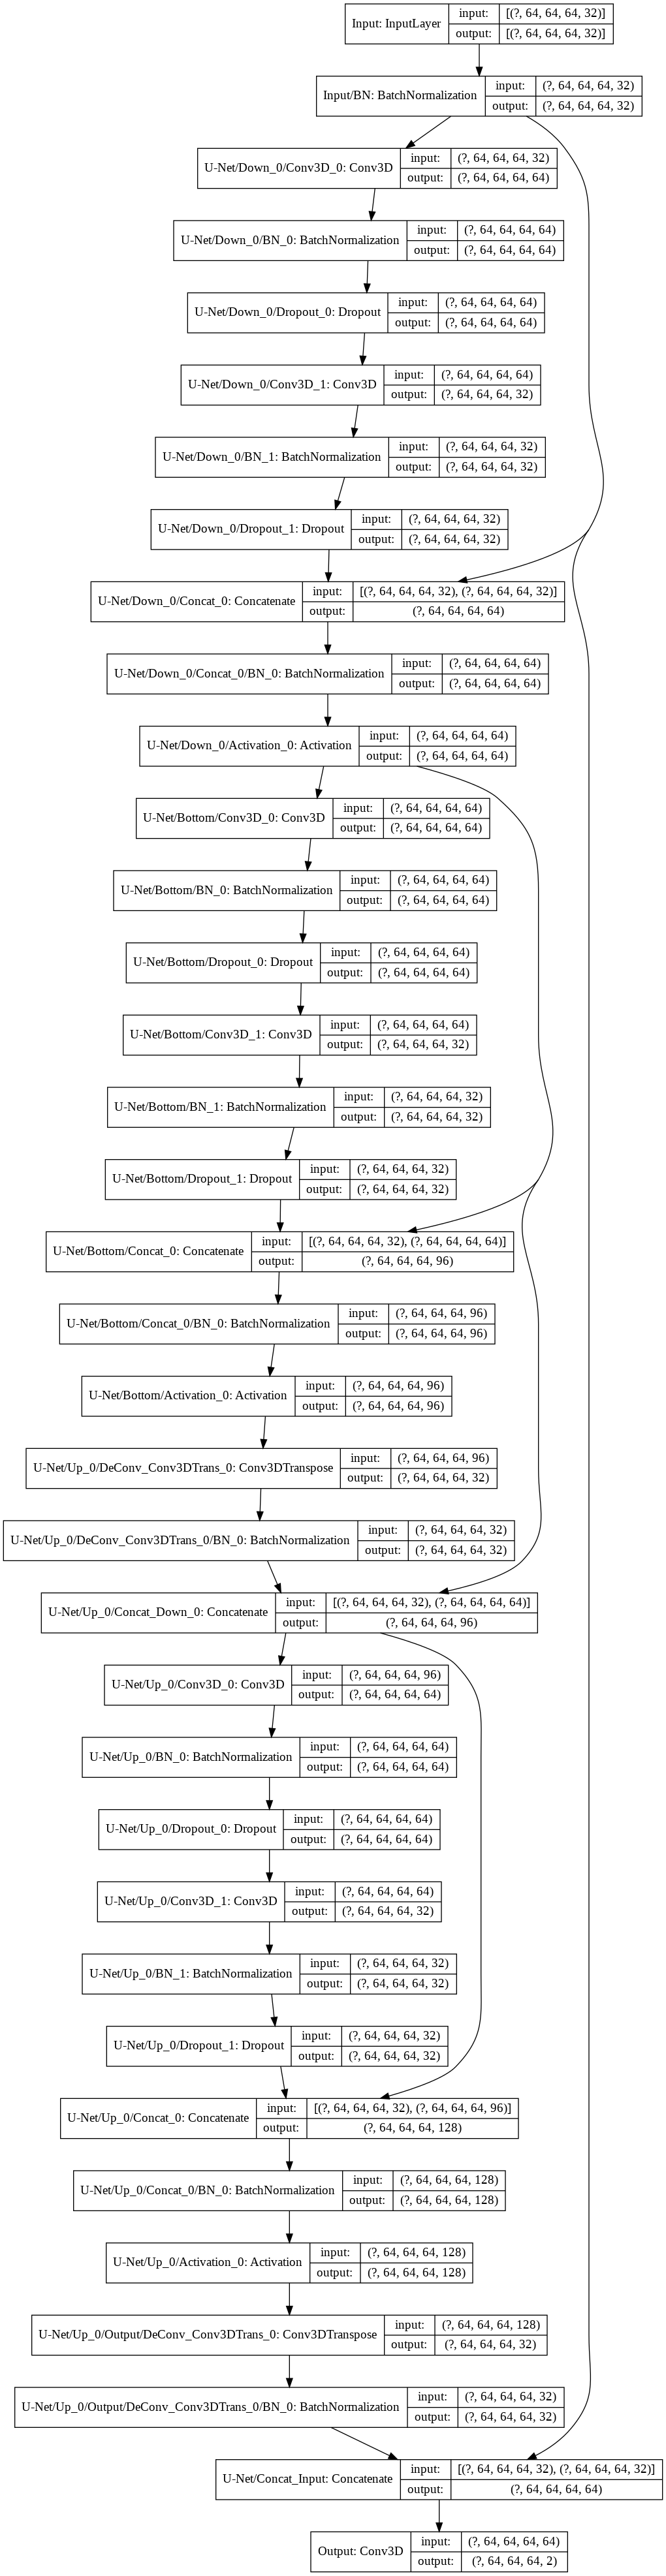

In [19]:
with tf.name_scope("Input"):
  input_layer = keras.Input(shape=x_train.shape[1:], name="Input")
  x=input_layer
  ##use Conv3D to make (?, 64,64,64,1) to (?,64,64,64,32)
  ##x = keras.layers.Conv3D(START_NUM_OF_FILTERS, kernel_size=3, padding="same",activation=keras.activations.relu, name="Input/Conv3D")(x)
  ##use Concat to make (?, 64,64,64,1) to (?,64,64,64,32)
  #for i in range(START_NUM_OF_FILTERS-1):
  #  x=keras.layers.Concatenate(axis=CHANNEL_AXIS)([x, input_layer])
  x = keras.layers.BatchNormalization(name="Input/BN")(x)
x = u_net(input_layer=x, filters=START_NUM_OF_FILTERS, conv_size=3, name = "U-Net", isres=ISRES, ispool=ISPOOL, 
          layer_depth=UNET_DEPTH, deconv=DECONV, isadd=False)

x = keras.layers.Conv3D(NUM_CLASS, kernel_size=3, padding="same",activation=keras.activations.relu, name="Output")(x)

model = keras.Model(input_layer, x, name="RUP-Net")

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
keras.utils.plot_model(model, 'RUP-Net.png', show_shapes=True)

In [1]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_set, epochs=EPOCH, validation_data=(x_test, y_test), validation_steps=BATCH_SIZE, callbacks=[earlystop])


NameError: ignored